In [1]:
import torch
import numpy as np
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-03
batch_size = 64
input_size = 64
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
import math

import torch
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch import nn
from torch.nn import Parameter
import pdb
import numpy as np


########################   Centeral-difference (second order, with 9 parameters and a const theta for 3x3 kernel) 2D Convolution   ##############################
## | a1 a2 a3 |   | w1 w2 w3 |
## | a4 a5 a6 | * | w4 w5 w6 | --> output = \sum_{i=1}^{9}(ai * wi) - \sum_{i=1}^{9}wi * a5 --> Conv2d (k=3) - Conv2d (k=1)
## | a7 a8 a9 |   | w7 w8 w9 |
##
##   --> output = 
## | a1 a2 a3 |   |  w1  w2  w3 |     
## | a4 a5 a6 | * |  w4  w5  w6 |  -  | a | * | w\_sum |     (kernel_size=1x1, padding=0)
## | a7 a8 a9 |   |  w7  w8  w9 |     

class Conv2d_cd(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.7):

        super(Conv2d_cd, self).__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.theta = theta

    def forward(self, x):
        out_normal = self.conv(x)

        if math.fabs(self.theta - 0.0) < 1e-8:
            return out_normal 
        else:
            #pdb.set_trace()
            [C_out,C_in, kernel_size,kernel_size] = self.conv.weight.shape
            kernel_diff = self.conv.weight.sum(2).sum(2)
            kernel_diff = kernel_diff[:, :, None, None]
            out_diff = F.conv2d(input=x, weight=kernel_diff, bias=self.conv.bias, stride=self.conv.stride, padding=0, groups=self.conv.groups)

            return out_normal - self.theta * out_diff


class SpatialAttention(nn.Module):
    def __init__(self, kernel = 3):
        super(SpatialAttention, self).__init__()


        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel, padding=kernel//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        
        return self.sigmoid(x)



class CDCN(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.7):   
        super(CDCN, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            basic_conv(128, 196, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(196),
            nn.ReLU(),  
            basic_conv(196, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),    
        )
        
        self.lastconv2 = nn.Sequential(
            basic_conv(128, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
        )
        
        self.lastconv3 = nn.Sequential(
            basic_conv(64, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )
        
        
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')

 
    def forward(self, x):	    	# x [3, 256, 256]
        
        x_input = x
        x = self.conv1(x)		   
        
        x_Block1 = self.Block1(x)	    	    	# x [128, 128, 128]
        x_Block1_32x32 = self.downsample32x32(x_Block1)   # x [128, 32, 32]  
        
        x_Block2 = self.Block2(x_Block1)	    # x [128, 64, 64]	  
        x_Block2_32x32 = self.downsample32x32(x_Block2)   # x [128, 32, 32]  
        
        x_Block3 = self.Block3(x_Block2)	    # x [128, 32, 32]  	
        x_Block3_32x32 = self.downsample32x32(x_Block3)   # x [128, 32, 32]  
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    # x [128*3, 32, 32]  
        
        #pdb.set_trace()
        
        x = self.lastconv1(x_concat)    # x [128, 32, 32] 
        x = self.lastconv2(x)    # x [64, 32, 32] 
        x = self.lastconv3(x)    # x [1, 32, 32] 
        
        map_x = x.squeeze(1)
        
        return map_x, x_concat, x_Block1, x_Block2, x_Block3, x_input

		

class CDCNpp(nn.Module):

    def __init__(self, basic_conv=Conv2d_cd, theta=0.0):   
        super(CDCNpp, self).__init__()
        
        
        self.conv1 = nn.Sequential(
            basic_conv(3, 64, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(64),
            nn.ReLU(),    
            
        )
        
        self.Block1 = nn.Sequential(
            basic_conv(64, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            basic_conv(128, int(128*1.6), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.6)),
            nn.ReLU(),  
            basic_conv(int(128*1.6), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
        )
        
        self.Block2 = nn.Sequential(
            basic_conv(128, int(128*1.2), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.2)),
            nn.ReLU(),  
            basic_conv(int(128*1.2), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            basic_conv(128, int(128*1.4), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.4)),
            nn.ReLU(),  
            basic_conv(int(128*1.4), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.Block3 = nn.Sequential(
            basic_conv(128, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            basic_conv(128, int(128*1.2), kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(int(128*1.2)),
            nn.ReLU(),  
            basic_conv(int(128*1.2), 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        # Original
        
        self.lastconv1 = nn.Sequential(
            basic_conv(128*3, 128, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            basic_conv(128, 1, kernel_size=3, stride=1, padding=1, bias=False, theta= theta),
            nn.ReLU(),    
        )
        
      
        self.sa1 = SpatialAttention(kernel = 7)
        self.sa2 = SpatialAttention(kernel = 5)
        self.sa3 = SpatialAttention(kernel = 3)
        self.downsample32x32 = nn.Upsample(size=(32, 32), mode='bilinear')

        self.fc = nn.Linear(1024, 102)
            
    def forward(self, x):
        
        x_input = x
        x = self.conv1(x)   
        
        x_Block1 = self.Block1(x)
        attention1 = self.sa1(x_Block1)
        x_Block1_SA = attention1 * x_Block1
        x_Block1_32x32 = self.downsample32x32(x_Block1_SA)   
        
        x_Block2 = self.Block2(x_Block1)    
        attention2 = self.sa2(x_Block2)  
        x_Block2_SA = attention2 * x_Block2
        x_Block2_32x32 = self.downsample32x32(x_Block2_SA)  
        
        x_Block3 = self.Block3(x_Block2)    
        attention3 = self.sa3(x_Block3)  
        x_Block3_SA = attention3 * x_Block3
        x_Block3_32x32 = self.downsample32x32(x_Block3_SA)   
        
        x_concat = torch.cat((x_Block1_32x32,x_Block2_32x32,x_Block3_32x32), dim=1)    
        
        #pdb.set_trace()
        map_x = self.lastconv1(x_concat)
    
        map_x = map_x.reshape(map_x.size(0), -1)

        map_x = self.fc(map_x)
        map_x = map_x.squeeze(1)
        return map_x
		

In [6]:
model1 = CDCNpp().to(device)
model2 = CDCNpp().to(device)

In [7]:
criteria = CostSensitiveRegularizedLoss(n_classes=num_of_class, base_loss='focal_loss', reduction='mean') 
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=1e-1)
model_name = 'cdcn_aug.pth'

Epoch: 1/10, Train Loss: 2.461692417395093,  Validation Loss: 2.2477692549045267
Validation Loss Decreased(inf ---> 2.2477692549045267)
Epoch: 2/10, Train Loss: 2.1529353541940064,  Validation Loss: 2.0930329331984887
Validation Loss Decreased(2.2477692549045267 ---> 2.0930329331984887)
Epoch: 3/10, Train Loss: 2.0465210577035786,  Validation Loss: 2.053894652770116
Validation Loss Decreased(2.0930329331984887 ---> 2.053894652770116)
Epoch: 4/10, Train Loss: 1.9945661801287076,  Validation Loss: 2.007474509569315
Validation Loss Decreased(2.053894652770116 ---> 2.007474509569315)
Epoch: 5/10, Train Loss: 1.9620075117858633,  Validation Loss: 2.0246601013036876
Epoch: 6/10, Train Loss: 1.9380603076790266,  Validation Loss: 1.9893609606302702
Validation Loss Decreased(2.007474509569315 ---> 1.9893609606302702)
Epoch: 7/10, Train Loss: 1.9234336738004703,  Validation Loss: 1.9467763625658476
Validation Loss Decreased(1.9893609606302702 ---> 1.9467763625658476)
Epoch: 8/10, Train Loss: 1.9

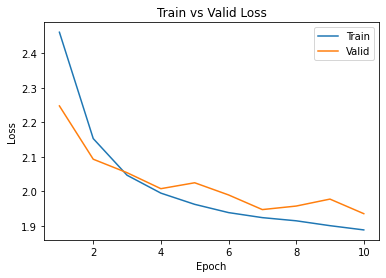

In [8]:
train(model1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=10, model_name=model_name)

In [9]:
model1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(model1, test_loader)
_ = evaluation(model1, train_loader)

Mean Absolute Error: 7.956155586242676
Minimum: 0.0, Maximum: 64.0, Median: 7.0
Mean Absolute Error: 7.459405422210693
Minimum: 0.0, Maximum: 53.0, Median: 6.0


In [10]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 61.00
2  No Sample
3 : 2 : 42.00
4 : 1 : 23.00
5 : 1 : 23.00
6 : 2 : 20.00
7 : 2 : 25.00
8 : 2 : 18.00
9 : 1 : 19.00
10 : 3 : 26.67
11 : 4 : 21.25
12 : 3 : 14.67
13 : 4 : 14.00
14 : 5 : 14.00
15 : 9 : 14.11
16 : 10 : 11.70
17 : 16 : 12.81
18 : 24 : 12.71
19 : 22 : 12.00
20 : 32 : 11.28
21 : 33 : 8.85
22 : 37 : 7.08
23 : 42 : 7.12
24 : 52 : 7.12
25 : 57 : 6.67
26 : 55 : 6.18
27 : 61 : 6.70
28 : 69 : 4.97
29 : 62 : 5.15
30 : 77 : 5.42
31 : 63 : 6.00
32 : 75 : 5.39
33 : 67 : 6.90
34 : 72 : 5.97
35 : 82 : 6.74
36 : 69 : 5.61
37 : 74 : 5.81
38 : 76 : 6.63
39 : 64 : 6.56
40 : 77 : 8.70
41 : 64 : 7.05
42 : 71 : 8.96
43 : 65 : 8.52
44 : 56 : 8.41
45 : 68 : 8.47
46 : 57 : 8.81
47 : 58 : 8.07
48 : 62 : 7.77
49 : 53 : 8.19
50 : 63 : 8.62
51 : 57 : 8.93
52 : 62 : 8.56
53 : 50 : 8.78
54 : 51 : 8.24
55 : 59 : 8.88
56 : 45 : 8.09
57 : 49 : 9.12
58 : 49 : 8.12
59 : 43 : 8.79
60 : 49 : 10.29
61 : 41 : 8.56
62 : 48 : 6.81
63 : 44 : 9.25
64 : 39 : 7.85
65 : 46 : 6.67
6

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/10, Train Loss: 2.736657124197944,  Validation Loss: 2.340480400965764
Validation Loss Decreased(inf ---> 2.340480400965764)
Epoch: 2/10, Train Loss: 2.261117322668845,  Validation Loss: 2.251740758235638
Validation Loss Decreased(2.340480400965764 ---> 2.251740758235638)
Epoch: 3/10, Train Loss: 2.155594169764229,  Validation Loss: 2.165382343989152
Validation Loss Decreased(2.251740758235638 ---> 2.165382343989152)
Epoch: 4/10, Train Loss: 2.0707513054431472,  Validation Loss: 2.097103137236375
Validation Loss Decreased(2.165382343989152 ---> 2.097103137236375)
Epoch: 5/10, Train Loss: 2.0025884163313807,  Validation Loss: 2.093622835782858
Validation Loss Decreased(2.097103137236375 ---> 2.093622835782858)
Epoch: 6/10, Train Loss: 1.9562621531565545,  Validation Loss: 2.074514013070327
Validation Loss Decreased(2.093622835782858 ---> 2.074514013070327)
Epoch: 7/10, Train Loss: 1.91116

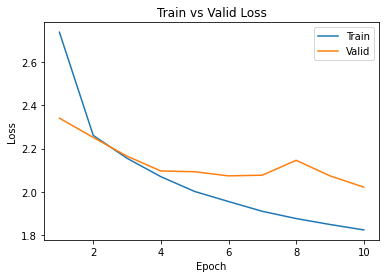

In [11]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = CostSensitiveRegularizedLoss(n_classes=num_of_class, base_loss='focal_loss', reduction='mean') 
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=1e-1)
model_name = 'cdcn.pth'
train(model2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=10, model_name=model_name)

In [12]:
model2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(model2, test_loader)
_ = evaluation(model2, train_loader)

Mean Absolute Error: 9.111279487609863
Minimum: 0.0, Maximum: 75.0, Median: 8.0
Mean Absolute Error: 7.388267993927002
Minimum: 0.0, Maximum: 50.0, Median: 6.0


In [13]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 37.00
2  No Sample
3 : 2 : 55.00
4 : 1 : 26.00
5 : 1 : 16.00
6 : 2 : 16.50
7 : 2 : 22.50
8 : 2 : 14.50
9 : 1 : 15.00
10 : 3 : 15.67
11 : 4 : 27.75
12 : 3 : 17.67
13 : 4 : 18.75
14 : 5 : 16.40
15 : 9 : 12.11
16 : 10 : 10.40
17 : 16 : 11.50
18 : 24 : 13.83
19 : 22 : 9.36
20 : 32 : 10.50
21 : 33 : 8.76
22 : 37 : 7.97
23 : 42 : 8.52
24 : 52 : 7.73
25 : 57 : 8.51
26 : 55 : 7.47
27 : 61 : 8.77
28 : 69 : 8.68
29 : 62 : 6.85
30 : 77 : 7.17
31 : 63 : 7.46
32 : 75 : 7.63
33 : 67 : 7.27
34 : 72 : 8.25
35 : 82 : 7.71
36 : 69 : 7.28
37 : 74 : 5.97
38 : 76 : 5.53
39 : 64 : 6.55
40 : 77 : 7.38
41 : 64 : 6.50
42 : 71 : 6.83
43 : 65 : 8.31
44 : 56 : 8.48
45 : 68 : 9.16
46 : 57 : 8.89
47 : 58 : 8.60
48 : 62 : 8.45
49 : 53 : 8.60
50 : 63 : 7.41
51 : 57 : 8.49
52 : 62 : 9.05
53 : 50 : 7.50
54 : 51 : 8.53
55 : 59 : 8.49
56 : 45 : 9.22
57 : 49 : 9.63
58 : 49 : 9.14
59 : 43 : 8.91
60 : 49 : 11.22
61 : 41 : 9.17
62 : 48 : 9.54
63 : 44 : 9.18
64 : 39 : 8.90
65 : 46 : 8.59
66